In [4]:
#List of required modules for the code

from osgeo import gdal, gdal_array as gdarr, ogr, osr
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

import pandas as pd
from pretty_confusion_matrix import pp_matrix

##### STEP 1 : Preparing the satellite image for classification:
    Prior steps:
        1. Download relevant satellite imagery, here Sentinel 2 imagery is downloaded with cloud cover < 10%
        2. Create a composite image using the multiple bands. Here, 10 m resolution image with the 4 bands R, G, B and NIR are used.

In [5]:
# Set location of the original imagery and the bounding box
compositefile = "./composite_4326.tif"
bandList = [band for band in compositefile]
bbvector = r"./BoundingBox.geojson"

In [6]:
# Crop the imagery using gdal warp. Set the name of the generated satellite imagery
gdal.UseExceptions()
SenegalDs = gdal.Warp(r".\Senegal_AOI.tif", compositefile,
format = 'GTiff',
cutlineDSName = bbvector,
dstNodata = -9999,
cropToCutline = True)
SenegalDs = None

In [7]:
# Read the generated cropped satellite image
Senegalfile = r".\Senegal_AOI.tif"
srcimg = gdal.Open(Senegalfile)

##### STEP 2: Rasterize the training samples for the algorithm
        1. Read the samples files (in geojson format in this example) and convert into a shapefile with an attribute with landcover classes assigned in numeric form
        2. Rasterize the updated shape file using the numerical class values as raster data value

In [8]:
# Open the training file
roi = ogr.Open(r".\Training_samples.geojson")
roi_lyr = roi.GetLayer()

Note: If the below step does not work due to memory issues or kernel issues, the training shape file is provided in the dataset. This step can be done in QGIS/ArcGIS if required. However, the code works too

In [ ]:
## SAVING THE TRAINING SAMPLES AS A SHAPEFILE WITH NUMERIC LAND CLASS LABELS
# set up the shapefile driver
driver = ogr.GetDriverByName("ESRI Shapefile")
# create the data source
data_source = driver.CreateDataSource("TrainingClasses.shp")
# # create the spatial reference , EPSG 4326
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
# create the layer
layer = data_source.CreateLayer("trainingsamples", srs,  geom_type = ogr.wkbPolygon )
# Add fields and create one field called Class
lc_class = ogr.FieldDefn("Class", ogr.OFTInteger )
layer.CreateField(lc_class)
# Set field values assigning a numeric code to each landcover class
for feat in roi_lyr:
    feature = ogr.Feature(layer.GetLayerDefn())
    val = feat.GetFieldAsString('LandCover')
    if val == 'Water body':
        feature.SetField("Class", 1)
    elif val == "Cropland":
        feature.SetField("Class", 2)
    elif val == 'Built-up surface':
        feature.SetField("Class", 3)
    elif val == 'Natural vegetation':
        feature.SetField("Class", 4)
    elif val == 'Bare soil':
        feature.SetField("Class", 5)
    else:
        feature.SetField("Class", 0)   #nodata
    feature.SetGeometry(feat.GetGeometryRef())
    layer.CreateFeature (feature)
    feature = None
data_source = None

In [10]:
# Open the generated shape file
roi_class = ogr.Open(r".\TrainingClasses.shp")
roi_cls_lyr = roi_class.GetLayer(0)

In [11]:
print (srcimg.RasterXSize , srcimg.RasterYSize)

2385 1810


In [12]:
#Create the raster data source using the size of the source image and 1 band
Driver = gdal.GetDriverByName('GTiff')
roiDs = Driver.Create('TrainingSample.tif', srcimg.RasterXSize , srcimg.RasterYSize , 1)
roiDs.SetProjection(srcimg.GetProjection())
# set projection
roiDs.SetGeoTransform(srcimg.GetGeoTransform())
# create 1 band and set the nodata value
outband1 = roiDs.GetRasterBand(1)
outband1.SetNoDataValue(0)

0

In [14]:
#Rasterize he layer using the values from the attribute field, class
gdal.RasterizeLayer(roiDs, [1], roi_cls_lyr, options=["ALL_TOUCHED=TRUE", "ATTRIBUTE=Class"])

0

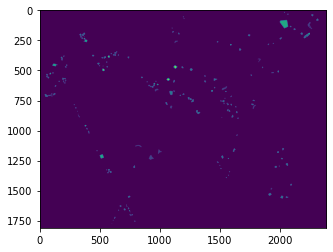

In [15]:
#Read the generated training sample raster file as an array and plot
roidata = roiDs.ReadAsArray()
plt.imshow ( roidata )
plt.grid ( False )
plt.show()

In [16]:
# Summary of the generated file
classes = np.unique(roidata)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roidata == c).sum()))

Class 0 contains 4288524 pixels
Class 1 contains 5178 pixels
Class 2 contains 16452 pixels
Class 3 contains 4538 pixels
Class 4 contains 1975 pixels
Class 5 contains 183 pixels


##### Step 3: Training the dataset
    1. Generate an array of the composite image with all the bands
    2. Read in the training samples and the corresponding values of the source image and split into training and testing
    3. Train the decision tree model

In [17]:
bandcount = srcimg.RasterCount
YSize = srcimg.RasterYSize
XSize = srcimg.RasterXSize
# Create an array of the size of the image with the number of bands 
img = np.zeros((YSize, XSize, bandcount), gdarr.GDALTypeCodeToNumericTypeCode(srcimg.GetRasterBand(1).DataType))
# Add pixel values in the array
for x in range(bandcount):
    img[:, :, x] = srcimg.GetRasterBand(x + 1).ReadAsArray()

In [18]:
print(img.shape)

(1810, 2385, 4)


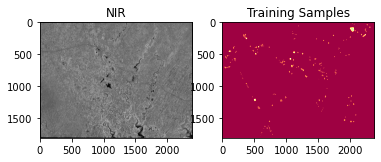

In [19]:
# Display the image and training sample
plt.subplot(121)
plt.imshow(img[:, :, 3], cmap=plt.cm.Greys_r)
plt.title('NIR')

plt.subplot(122)
plt.imshow(roidata, cmap=plt.cm.Spectral)
plt.title('Training Samples')

plt.show()

In [20]:
# Get the number of training samples
n_samples = (roidata > 0).sum()
print('We have {n} samples'.format(n=n_samples))

We have 28326 samples


In [21]:
# Training Classes and labels
labels = np.unique(roidata[roidata > 0])
label_cat = {1: 'Water Body' , 2: 'Cropland', 3: 'Built-up Surface', 4: 'Natural Vegetation', 5: 'Bare soil'}
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=label_cat.values()))

The training data include 5 classes: dict_values(['Water Body', 'Cropland', 'Built-up Surface', 'Natural Vegetation', 'Bare soil'])


In [22]:
X = np.array([], dtype=np.int8).reshape(0,4) # pixels for training
Y = np.array([], dtype=np.string_) # labels for training

X = img[roidata > 0, :]
Y = roidata[roidata > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our Y array is sized: {sz}'.format(sz=Y.shape))

Our X matrix is sized: (28326, 4)
Our Y array is sized: (28326,)


In [42]:
#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify = Y, random_state = 1)

In [43]:
# Decision Tree Classifier algorithm on the training data
clf=DecisionTreeClassifier(max_depth = 10)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_train)

#Accuracy
print("Accuracy of the model : ", accuracy_score(y_train, y_pred))
print("Kappa Score of the model : ", cohen_kappa_score(y_train, y_pred))

Accuracy of the model :  0.7292717369376639
Kappa Score of the model :  0.47357606583881984


In [44]:
# Confusion Matrix
cfmatrix = confusion_matrix(y_train, y_pred)
print(cfmatrix)

[[ 2372  1048   179    26     0]
 [  181 10982   278    75     0]
 [  192  2070   899    16     0]
 [   61  1039    77   205     0]
 [    0   126     0     0     2]]


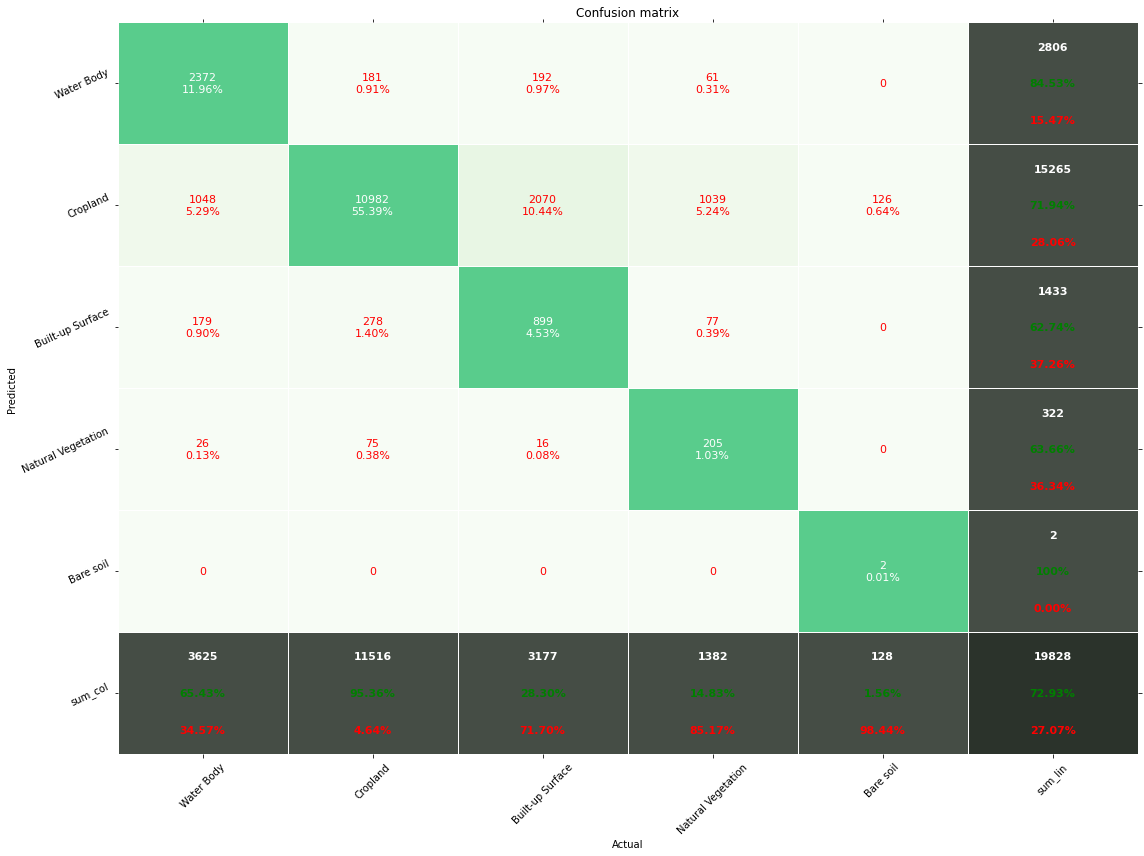

In [45]:
#Confusion matrix with percentages
df_cm = pd.DataFrame(cfmatrix, index = label_cat.values(), columns=label_cat.values())
pp_matrix(df_cm, cmap='Greens', figsize = [16, 12], show_null_values=1)

##### Step 4: Classify the image and visualize

In [46]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], 4)

img_as_array = img[:, :, :4].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = clf.predict(img_as_array)

# Reshape our classification map into a raster with 1 band
class_prediction = class_prediction.reshape(img[:, :, 1].shape)

Reshaped from (1810, 2385, 4) to (4316850, 4)


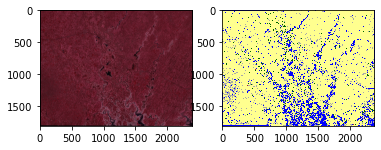

In [47]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [3,2,1], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 0, 255, 255)),  # Water body (Blue)
    (2, (255, 255, 143, 255)),  # Cropland (Yellow)
    (3, (169, 169, 169, 255)),  # Built-up surface (grey)
    (4, (0, 100, 0, 255)),  # Natural vegetation (Green)
    (5, (165, 42, 42, 255))  # Bare soil (Brownw)
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

In [51]:
#Save the classified image
driver = gdal.GetDriverByName('GTiff')      # we can choose a diferent format e.g. XYZ
newRaster = driver.Create('LCSenegal.tif',class_prediction.shape[1],class_prediction.shape[0], 1)
prj = srcimg.GetProjection()                         # define new raster dataset proj. & geotransform
newRaster.SetProjection(prj)
newRaster.SetGeoTransform(srcimg.GetGeoTransform())
# We can use the same GT because TL is same
newBand = newRaster.GetRasterBand(1) # get band 1 so we can fill it with data
newBand.WriteArray(class_prediction)                          # write the array to the band
newBand.SetNoDataValue(-9999)             # set a pixel nodata value
newBand.FlushCache()                              # flush the cache and clean memory
newBand = None

0